In [ ]:
!pip install rdkit-pypi torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.6 MB/s eta 0:00:00


In [ ]:
# Core PyTorch and data handling
import torch
from torch.utils.data import DataLoader
import pandas as pd

In [ ]:
# Test individual imports first
print("Testing individual imports...")

try:
    from smile_to_graph import SMILESToGraph
    print("✓ SMILESToGraph imported")
except Exception as e:
    print(f"✗ SMILESToGraph failed: {e}")

try:
    from cl_dataset import ContrastiveDataset
    print("✓ ContrastiveDataset imported")
except Exception as e:
    print(f"✗ ContrastiveDataset failed: {e}")

try:
    from cl_model import ContrastiveLearningModel
    print("✓ ContrastiveLearningModel imported")
except Exception as e:
    print(f"✗ ContrastiveLearningModel failed: {e}")

try:
    from util import collate_contrastive, train_contrastive_model
    print("✓ Util functions imported")
except Exception as e:
    print(f"✗ Util functions failed: {e}")

Testing individual imports...
✓ SMILESToGraph imported
✓ ContrastiveDataset imported
✓ ContrastiveLearningModel imported
✓ Util functions imported


In [ ]:
# Test dataset creation
example_smiles = ["CCO", "CC(C)O", "c1ccccc1", "c1ccc(C)cc1"]
dataset = ContrastiveDataset(example_smiles, similarity_threshold=0.3)
print(f"Dataset created with {len(dataset)} examples")

Valid molecules: 4 / 4
Found 0 positive pairs
Dataset created with 0 examples


Before I start, I'd like to list out some assumptions and problems to make this task more approachable.

Problems:
- Lots of missing data, but FFV seems to be mostly complete
- There is some additional data that seems useful but idrk the efficacy of this data, will need to do something smart to use this
- I think there is some merit in trying to find relations between different properties between materials and choosing how to go about it this way

assumptions:
- Similar chemical structures have similar properties, making this very clearly a language problem, we can maybe use some sort of attention mechanism to learn what structures exist within the material
- We can test this idea by seeing how well we perform at FFV and then try to see what we can do with the rest


In [ ]:
#load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
print(train.head())

       id                                             SMILES  Tg       FFV  \
0   87817                         *CC(*)c1ccccc1C(=O)OCCCCCC NaN  0.374645   
1  106919  *Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5... NaN  0.370410   
2  388772  *Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(... NaN  0.378860   
3  519416  *Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)... NaN  0.387324   
4  539187  *Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N... NaN  0.355470   

         Tc  Density  Rg  
0  0.205667      NaN NaN  
1       NaN      NaN NaN  
2       NaN      NaN NaN  
3       NaN      NaN NaN  
4       NaN      NaN NaN  


In [ ]:
smiles = list(train['SMILES'])
add_smiles = pd.read_csv('dataset2.csv')
add_smiles = list(add_smiles['SMILES'])
print(len(smiles), len(add_smiles))
tot_smiles = list(set(smiles + add_smiles))

7973 7208


In [ ]:
# Example SMILES strings to test
example_smiles = [
        "CCO",  # ethanol
        "CC(C)O",  # isopropanol
        "CCCCCCCCCCCCCCCCCC(=O)O",  # stearic acid
        "CC(C)(C)C",  # tert-butane
        "c1ccccc1",  # benzene
        "c1ccc2c(c1)cccc2",  # naphthalene
        "CC(=O)O",  # acetic acid
        "CC(C)(C)O"  # tert-butanol
    ]
print("Setting up contrastive learning...")

# Create dataset
dataset = ContrastiveDataset(example_smiles, similarity_threshold=0.3)  # Lower threshold for small example
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_contrastive)

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ContrastiveLearningModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Training on {device}")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

# Train model
train_contrastive_model(model, dataloader, optimizer, device, num_epochs=5)

Setting up contrastive learning...
Valid molecules: 8 / 8
Found 2 positive pairs
Training on cuda
Model has 441280 parameters


Epoch 1/5: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it, Loss=0.6978]


Epoch 1, Average Loss: 0.6978


Epoch 2/5: 100%|██████████| 1/1 [00:00<00:00, 30.29it/s, Loss=0.7123]


Epoch 2, Average Loss: 0.7123


Epoch 3/5: 100%|██████████| 1/1 [00:00<00:00, 35.68it/s, Loss=0.6915]


Epoch 3, Average Loss: 0.6915


Epoch 4/5: 100%|██████████| 1/1 [00:00<00:00, 32.94it/s, Loss=0.6549]


Epoch 4, Average Loss: 0.6549


Epoch 5/5: 100%|██████████| 1/1 [00:00<00:00, 36.25it/s, Loss=0.5911]

Epoch 5, Average Loss: 0.5911


In [ ]:
for threshold in [0.8, 0.7, 0.6]:
    print(f"\n--- Testing threshold {threshold} ---")
    dataset = ContrastiveDataset(tot_smiles[:1000], similarity_threshold=threshold)  # Test on first 1000
    print(f"Found {len(dataset.positive_pairs)} positive pairs")


--- Testing threshold 0.8 ---
Valid molecules: 1000 / 1000
Found 304 positive pairs
Found 304 positive pairs

--- Testing threshold 0.7 ---
Valid molecules: 1000 / 1000
Found 602 positive pairs
Found 602 positive pairs

--- Testing threshold 0.6 ---
Valid molecules: 1000 / 1000
Found 969 positive pairs
Found 969 positive pairs


In [11]:
# Create dataset
dataset = ContrastiveDataset(tot_smiles, similarity_threshold=0.7)  # Lower threshold for small example

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ContrastiveLearningModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Training on {device}")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_contrastive)
train_contrastive_model(model, dataloader, optimizer, device, num_epochs=50)

Valid molecules: 9956 / 9956
Found 18652 positive pairs
Training on cuda
Model has 441280 parameters


Epoch 1/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0903]


Epoch 1, Average Loss: 0.1319


Epoch 2/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0256]


Epoch 2, Average Loss: 0.0800


Epoch 3/50: 100%|██████████| 583/583 [13:12<00:00,  1.36s/it, Loss=0.0198]


Epoch 3, Average Loss: 0.0404


Epoch 4/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0237]


Epoch 4, Average Loss: 0.0311


Epoch 5/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0092]


Epoch 5, Average Loss: 0.0256


Epoch 6/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0012]


Epoch 6, Average Loss: 0.0208


Epoch 7/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0118]


Epoch 7, Average Loss: 0.0203


Epoch 8/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0199]


Epoch 8, Average Loss: 0.0182


Epoch 9/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0197]


Epoch 9, Average Loss: 0.0190


Epoch 10/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0141]


Epoch 10, Average Loss: 0.0164


Epoch 11/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0350]


Epoch 11, Average Loss: 0.0157


Epoch 12/50: 100%|██████████| 583/583 [13:15<00:00,  1.36s/it, Loss=0.0089]


Epoch 12, Average Loss: 0.0144


Epoch 13/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0064]


Epoch 13, Average Loss: 0.0149


Epoch 14/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0028]


Epoch 14, Average Loss: 0.0136


Epoch 15/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0040]


Epoch 15, Average Loss: 0.0123


Epoch 16/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0120]


Epoch 16, Average Loss: 0.0122


Epoch 17/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0007]


Epoch 17, Average Loss: 0.0109


Epoch 18/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0059]


Epoch 18, Average Loss: 0.0102


Epoch 19/50: 100%|██████████| 583/583 [13:12<00:00,  1.36s/it, Loss=0.0029]


Epoch 19, Average Loss: 0.0106


Epoch 20/50: 100%|██████████| 583/583 [13:15<00:00,  1.37s/it, Loss=0.0023]


Epoch 20, Average Loss: 0.0087


Epoch 21/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0017]


Epoch 21, Average Loss: 0.0107


Epoch 22/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0040]


Epoch 22, Average Loss: 0.0102


Epoch 23/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0056]


Epoch 23, Average Loss: 0.0093


Epoch 24/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0013]


Epoch 24, Average Loss: 0.0072


Epoch 25/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0210]


Epoch 25, Average Loss: 0.0086


Epoch 26/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0005]


Epoch 26, Average Loss: 0.0090


Epoch 27/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0004]


Epoch 27, Average Loss: 0.0084


Epoch 28/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0169]


Epoch 28, Average Loss: 0.0084


Epoch 29/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0020]


Epoch 29, Average Loss: 0.0074


Epoch 30/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0155]


Epoch 30, Average Loss: 0.0073


Epoch 31/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0066]


Epoch 31, Average Loss: 0.0087


Epoch 32/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0020]


Epoch 32, Average Loss: 0.0083


Epoch 33/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0011]


Epoch 33, Average Loss: 0.0075


Epoch 34/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0047]


Epoch 34, Average Loss: 0.0066


Epoch 35/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0022]


Epoch 35, Average Loss: 0.0069


Epoch 36/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0104]


Epoch 36, Average Loss: 0.0073


Epoch 37/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0022]


Epoch 37, Average Loss: 0.0076


Epoch 38/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0014]


Epoch 38, Average Loss: 0.0062


Epoch 39/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0014]


Epoch 39, Average Loss: 0.0062


Epoch 40/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0055]


Epoch 40, Average Loss: 0.0067


Epoch 41/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0086]


Epoch 41, Average Loss: 0.0063


Epoch 42/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0383]


Epoch 42, Average Loss: 0.0068


Epoch 43/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0174]


Epoch 43, Average Loss: 0.0065


Epoch 44/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0006]


Epoch 44, Average Loss: 0.0062


Epoch 45/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0011]


Epoch 45, Average Loss: 0.0067


Epoch 46/50: 100%|██████████| 583/583 [13:13<00:00,  1.36s/it, Loss=0.0200]


Epoch 46, Average Loss: 0.0053


Epoch 47/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0005]


Epoch 47, Average Loss: 0.0072


Epoch 48/50: 100%|██████████| 583/583 [13:15<00:00,  1.36s/it, Loss=0.0073]


Epoch 48, Average Loss: 0.0080


Epoch 49/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0174]


Epoch 49, Average Loss: 0.0084


Epoch 50/50: 100%|██████████| 583/583 [13:14<00:00,  1.36s/it, Loss=0.0101]

Epoch 50, Average Loss: 0.0079


NameError: name 'epoch' is not defined

In [13]:
# Save the encoder (after training is complete)
torch.save(model.encoder.state_dict(), 'pretrained_encoder.pth')
print("Encoder saved!")

Encoder saved!


In [12]:
torch.save(model.state_dict(), 'full_contrastive_model.pth')
print("Full model saved!")

Full model saved!


In [14]:
import numpy as np

In [18]:
# Load your full contrastive model
model = ContrastiveLearningModel()
model.load_state_dict(torch.load('full_contrastive_model.pth'))
model.eval()
model = model.to(device)

# Extract just the encoder
encoder = model.encoder
print("Encoder extracted from full model!")

# Load training data
smiles_list = train['SMILES'].tolist()
print(f"Total molecules to process: {len(smiles_list)}")

# Initialize graph converter
graph_converter = SMILESToGraph()

# Extract embeddings
embeddings = []
valid_indices = []

print("Extracting embeddings...")
for i, smiles in enumerate(smiles_list):
    try:
        # Convert SMILES to graph
        graph = graph_converter.smiles_to_graph(smiles)
        if graph is not None:
            graph = graph.to(device)

            # Add batch information (required for PyTorch Geometric)
            graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long, device=device)

            # Get embedding from encoder
            with torch.no_grad():
                embedding = encoder(graph)  # Should give 256-dim vector
                embeddings.append(embedding.cpu().numpy().flatten())
                valid_indices.append(i)

        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1}/{len(smiles_list)} molecules...")

    except Exception as e:
        print(f"Failed to process molecule {i}: {e}")

embeddings = np.array(embeddings)
valid_indices = np.array(valid_indices)

print(f"\nSuccessfully extracted {len(embeddings)} embeddings")
print(f"Embedding shape: {embeddings.shape}")
print(f"Failed molecules: {len(smiles_list) - len(embeddings)}")

# Save them
np.save('molecular_embeddings.npy', embeddings)
np.save('valid_indices.npy', valid_indices)
print("Embeddings saved!")

Encoder extracted from full model!
Total molecules to process: 7973
Extracting embeddings...
Processed 500/7973 molecules...
Processed 1000/7973 molecules...
Processed 1500/7973 molecules...
Processed 2000/7973 molecules...
Processed 2500/7973 molecules...
Processed 3000/7973 molecules...
Processed 3500/7973 molecules...
Processed 4000/7973 molecules...
Processed 4500/7973 molecules...
Processed 5000/7973 molecules...
Processed 5500/7973 molecules...
Processed 6000/7973 molecules...
Processed 6500/7973 molecules...
Processed 7000/7973 molecules...
Processed 7500/7973 molecules...

Successfully extracted 7973 embeddings
Embedding shape: (7973, 256)
Failed molecules: 0
Embeddings saved!


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [20]:
# Map embeddings back to original dataframe indices
train_valid = train.iloc[valid_indices].reset_index(drop=True)
train_valid

,id,SMILES,Tg,FFV,Tc,Density,Rg
0,87817,*CC(*)c1ccccc1C(=O)OCCCCCC,NaN,0.374645,0.205667,NaN,NaN
1,106919,*Nc1ccc([C@H](CCC)c2ccc(C3(c4ccc([C@@H](CCC)c5...,NaN,0.370410,NaN,NaN,NaN
2,388772,*Oc1ccc(S(=O)(=O)c2ccc(Oc3ccc(C4(c5ccc(Oc6ccc(...,NaN,0.378860,NaN,NaN,NaN
3,519416,*Nc1ccc(-c2c(-c3ccc(C)cc3)c(-c3ccc(C)cc3)c(N*)...,NaN,0.387324,NaN,NaN,NaN
4,539187,*Oc1ccc(OC(=O)c2cc(OCCCCCCCCCOCC3CCCN3c3ccc([N...,NaN,0.355470,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7968,2146592435,*Oc1cc(CCCCCCCC)cc(OC(=O)c2cccc(C(*)=O)c2)c1,NaN,0.367498,NaN,NaN,NaN
7969,2146810552,*C(=O)OCCN(CCOC(=O)c1ccc2c(c1)C(=O)N(c1cccc(N3...,NaN,0.353280,NaN,NaN,NaN
7970,2147191531,*c1cc(C(=O)NCCCCCCCC)cc(N2C(=O)c3ccc(-c4ccc5c(...,NaN,0.369411,NaN,NaN,NaN
7971,2147435020,*C=C(*)c1ccccc1C,261.662355,NaN,NaN,NaN,NaN


In [21]:
# Focus on FFV (best coverage)
ffv_mask = ~pd.isna(train_valid['FFV'])
X_ffv = embeddings[ffv_mask]
y_ffv = train_valid['FFV'][ffv_mask].values

print(f"FFV samples: {len(X_ffv)} / {len(embeddings)} ({len(X_ffv)/len(embeddings)*100:.1f}%)")
print(f"FFV range: {y_ffv.min():.3f} to {y_ffv.max():.3f}")

FFV samples: 7030 / 7973 (88.2%)
FFV range: 0.227 to 0.777


In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ffv, y_ffv, test_size=0.2, random_state=42)


Training XGBoost...
XGBoost - Train MAE: 0.0019, Test MAE: 0.0101

Training RandomForest...
RandomForest - Train MAE: 0.0037, Test MAE: 0.0098

Best model: RandomForest with Test MAE: 0.0098


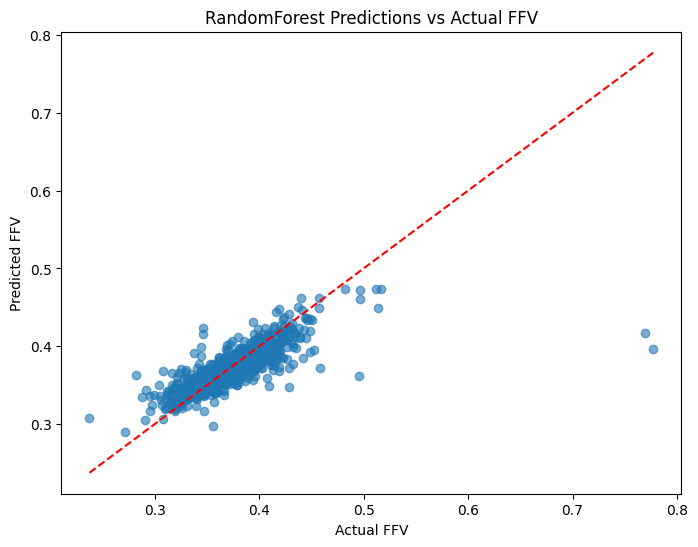

In [23]:
# Try multiple models
models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, eval_metric='mae'),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    results[name] = {'train_mae': train_mae, 'test_mae': test_mae, 'model': model}

    print(f"{name} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

# Show best model
best_model = min(results.keys(), key=lambda x: results[x]['test_mae'])
print(f"\nBest model: {best_model} with Test MAE: {results[best_model]['test_mae']:.4f}")

# Plot predictions vs actual
best_pred = results[best_model]['model'].predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual FFV')
plt.ylabel('Predicted FFV')
plt.title(f'{best_model} Predictions vs Actual FFV')
plt.show()

In [27]:
# First, train a stronger FFV model (your foundation)
print("=== Training Enhanced FFV Model ===")
ffv_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    random_state=42,
    eval_metric='mae'
)

ffv_model.fit(X_train, y_train)  # Using your existing FFV split
ffv_train_pred = ffv_model.predict(X_train)
ffv_test_pred = ffv_model.predict(X_test)

print(f"Enhanced FFV Model:")
print(f"Train MAE: {mean_absolute_error(y_train, ffv_train_pred):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, ffv_test_pred):.4f}")

# Now predict properties with sparse data using transfer learning
def train_sparse_property(property_name):
    print(f"\n=== Training {property_name} with Transfer Learning ===")

    # Get samples with this property
    prop_mask = ~pd.isna(train_valid[property_name])
    X_prop = embeddings[prop_mask]
    y_prop = train_valid[property_name][prop_mask].values

    print(f"{property_name} samples: {len(X_prop)} ({len(X_prop)/len(embeddings)*100:.1f}% coverage)")
    print(f"{property_name} range: {y_prop.min():.3f} to {y_prop.max():.3f}")

    # Add FFV predictions as extra features
    ffv_predictions = ffv_model.predict(X_prop)
    X_enhanced = np.column_stack([X_prop, ffv_predictions])  # 256 + 1 = 257 features

    # Train-test split
    X_train_prop, X_test_prop, y_train_prop, y_test_prop = train_test_split(
        X_enhanced, y_prop, test_size=0.2, random_state=42
    )

    # Train model with transfer learning features
    models = {
        'XGBoost': xgb.XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.1, random_state=42),
        'XGBoost_Deep': xgb.XGBRegressor(n_estimators=500, max_depth=6, learning_rate=0.05, random_state=42)
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train_prop, y_train_prop)

        train_pred = model.predict(X_train_prop)
        test_pred = model.predict(X_test_prop)

        train_mae = mean_absolute_error(y_train_prop, train_pred)
        test_mae = mean_absolute_error(y_test_prop, test_pred)

        results[name] = {
            'model': model,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'test_actual': y_test_prop,
            'test_pred': test_pred
        }

        print(f"{name} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

    # Return best model
    best_name = min(results.keys(), key=lambda x: results[x]['test_mae'])
    print(f"Best {property_name} model: {best_name}")

    return results[best_name], results

# Train all sparse properties
sparse_properties = ['Tg', 'Tc', 'Density', 'Rg']
property_models = {}

for prop in sparse_properties:
    best_model, all_results = train_sparse_property(prop)
    property_models[prop] = best_model

# Summary of all results
print("\n=== TRANSFER LEARNING SUMMARY ===")
print(f"FFV (baseline): {mean_absolute_error(y_test, ffv_test_pred):.4f} MAE")
for prop in sparse_properties:
    mae = property_models[prop]['test_mae']
    samples = len(property_models[prop]['test_actual'])
    print(f"{prop}: {mae:.4f} MAE ({samples} test samples)")

=== Training Enhanced FFV Model ===
Enhanced FFV Model:
Train MAE: 0.0023
Test MAE: 0.0093

=== Training Tg with Transfer Learning ===
Tg samples: 511 (6.4% coverage)
Tg range: -148.030 to 472.250
XGBoost - Train MAE: 0.4993, Test MAE: 62.7285
XGBoost_Deep - Train MAE: 0.0271, Test MAE: 63.7605
Best Tg model: XGBoost

=== Training Tc with Transfer Learning ===
Tc samples: 737 (9.2% coverage)
Tc range: 0.046 to 0.524
XGBoost - Train MAE: 0.0021, Test MAE: 0.0312
XGBoost_Deep - Train MAE: 0.0008, Test MAE: 0.0304
Best Tc model: XGBoost_Deep

=== Training Density with Transfer Learning ===
Density samples: 613 (7.7% coverage)
Density range: 0.749 to 1.841
XGBoost - Train MAE: 0.0009, Test MAE: 0.0450
XGBoost_Deep - Train MAE: 0.0006, Test MAE: 0.0461
Best Density model: XGBoost

=== Training Rg with Transfer Learning ===
Rg samples: 614 (7.7% coverage)
Rg range: 9.728 to 34.673
XGBoost - Train MAE: 0.0500, Test MAE: 1.7879
XGBoost_Deep - Train MAE: 0.0056, Test MAE: 1.8143
Best Rg model: 

In [28]:
# Load test data and predict all properties
print("=== PREDICTING ON TEST DATASET ===")

# Load test data
test_df = pd.read_csv('test.csv')  # Assuming you have this
test_smiles = test_df['SMILES'].tolist()

print(f"Test dataset size: {len(test_smiles)}")

# Extract embeddings for test molecules
print("Extracting test embeddings...")
test_embeddings = []
test_valid_indices = []

for i, smiles in enumerate(test_smiles):
    try:
        graph = graph_converter.smiles_to_graph(smiles)
        if graph is not None:
            graph = graph.to(device)
            graph.batch = torch.zeros(graph.x.size(0), dtype=torch.long, device=device)

            with torch.no_grad():
                embedding = encoder(graph)
                test_embeddings.append(embedding.cpu().numpy().flatten())
                test_valid_indices.append(i)

        if (i + 1) % 500 == 0:
            print(f"Processed {i + 1}/{len(test_smiles)} test molecules...")

    except Exception as e:
        print(f"Failed to process test molecule {i}: {e}")

test_embeddings = np.array(test_embeddings)
print(f"Successfully extracted {len(test_embeddings)} test embeddings")

# Predict FFV first
ffv_test_pred = ffv_model.predict(test_embeddings)

# Predict all properties using the trained models
predictions = {}

# FFV predictions
predictions['FFV'] = ffv_test_pred

# Predict sparse properties using transfer learning
for prop in ['Tg', 'Tc', 'Density', 'Rg']:
    # Add FFV as feature
    test_enhanced = np.column_stack([test_embeddings, ffv_test_pred])

    # Predict using best model for this property
    model = property_models[prop]['model']
    predictions[prop] = model.predict(test_enhanced)

    print(f"{prop} predictions - Range: {predictions[prop].min():.3f} to {predictions[prop].max():.3f}")

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'].iloc[test_valid_indices],  # Only valid molecules
    'Tg': predictions['Tg'],
    'FFV': predictions['FFV'],
    'Tc': predictions['Tc'],
    'Density': predictions['Density'],
    'Rg': predictions['Rg']
})

# For failed molecules, fill with median values from training
if len(test_valid_indices) < len(test_smiles):
    print(f"Warning: {len(test_smiles) - len(test_valid_indices)} molecules failed processing")

    # You'll need to handle failed molecules - maybe fill with training medians
    # Or use simpler fingerprint-based predictions

print(f"Submission shape: {submission.shape}")
print("\nFirst few predictions:")
print(submission.head())

# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission saved!")

=== PREDICTING ON TEST DATASET ===
Test dataset size: 3
Extracting test embeddings...
Successfully extracted 3 test embeddings
Tg predictions - Range: 54.218 to 188.528
Tc predictions - Range: 0.203 to 0.250
Density predictions - Range: 1.085 to 1.126
Rg predictions - Range: 16.643 to 22.533
Submission shape: (3, 6)

First few predictions:
           id          Tg       FFV        Tc   Density         Rg
0  1109053969  188.527740  0.380173  0.250211  1.084848  16.642508
1  1422188626  172.660080  0.382704  0.218605  1.125719  22.533390
2  2032016830   54.218235  0.347141  0.203189  1.090924  19.499699
Submission saved!
